In [7]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft2, ifft2, fftshift
from joblib import Parallel, delayed
import PIL
from ttictoc import tic, toc 
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter  
from skimage import io

from cupy_common import check_cupy_available

gpu_accelerated = check_cupy_available()

if gpu_accelerated:
    print("Running on GPU")
    cp = __import__("cupy")
else:
    print("Running on CPU")
    cp = __import__("numpy")

#creates the colohweel
def bldclrwhl(nx, ny, sym):
    cda = cp.ones((nx, ny,2))
    cx = cp.linspace(-nx,nx,nx)
    cy = cp.linspace(-ny,ny,ny)
    cxx, cyy = cp.meshgrid(cy,cx)
    czz =(((cp.arctan2(cxx, cyy) / math.pi) + 1.0) / 2.0)*sym
    cd2 = cp.dstack((czz, cda))
    carr = cd2
    chi = cp.floor(carr[..., 0] * 6)
    f = carr[..., 0] * 6 - chi
    p = carr[..., 2] * (1 - carr[..., 1])
    q = carr[..., 2] * (1 - f * carr[..., 1])
    t = carr[..., 2] * (1 - (1 - f) * carr[..., 1])
    v = carr[..., 2]
    chi = cp.stack([chi, chi, chi], axis=-1).astype(cp.uint8) % 6
    out = cp.choose(
        chi, cp.stack([cp.stack((v, t, p), axis=-1),
                      cp.stack((q, v, p), axis=-1),
                      cp.stack((p, v, t), axis=-1),
                      cp.stack((p, q, v), axis=-1),
                      cp.stack((t, p, v), axis=-1),
                      cp.stack((v, p, q), axis=-1)]))
    if gpu_accelerated:
        imnp = cp.asnumpy(out)
    else:
        imnp = out
    return imnp

def nofft(whl, img, nx, ny):
    imnp = cp.array(img)
    fimg = cp.fft.fft2(imnp)
    whl  = cp.fft.fftshift(whl)
    proimg = cp.zeros((nx,ny,3))
    comb = cp.zeros((nx,ny,3), dtype=complex)
    magnitude = cp.repeat(np.abs(fimg)[:,:,np.newaxis], 3, axis=2)
    phase = cp.repeat(np.angle(fimg)[:,:,np.newaxis], 3, axis=2)
    proimg = whl*magnitude
    comb = cp.multiply(proimg, cp.exp(1j*phase))
    for n in range(3):
        proimg[:, :, n] = cp.real(cp.fft.ifft2(comb[:,:,n]))
        proimg[:, :, n] = proimg[:, :, n] - cp.min(proimg[:, :, n])
        proimg[:, :, n] = proimg[:, :, n] / cp.max(proimg[:, :, n])
            
    if gpu_accelerated:
        proimg = cp.asnumpy(proimg)
    return proimg


Running on GPU


In [8]:
#Read Image
data = Image.open('../data/block_2.tif')
data = np.array(data)[:,:]
print(data.shape)
symmetry = 6


(1890, 1962)


0.07319637500040699


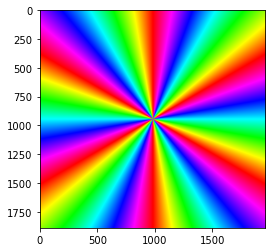

0.11827250300120795


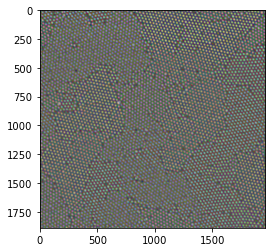

0.31114777400216553


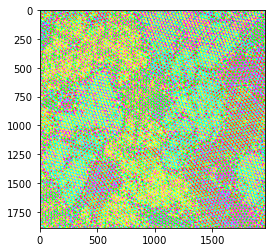

In [9]:

tic()
clrwhl = bldclrwhl(data.shape[0], data.shape[1],symmetry)
print(toc())
plt.imshow(clrwhl)
plt.show()

tic()
imnp = nofft(clrwhl, data, data.shape[0], data.shape[1])
print(toc())
plt.imshow(imnp)
plt.show()
tic()
imnp = imnp-np.min(imnp)
imnp = imnp/np.max(imnp)*255
rgb2 = Image.fromarray(np.uint8(imnp))
img2 = rgb2.filter(ImageFilter.GaussianBlur(radius = 0.0)) 
converter = PIL.ImageEnhance.Color(img2)
img2 = converter.enhance(7.6)
converter = PIL.ImageEnhance.Brightness(img2)
img2 = converter.enhance(2.7)
converter = PIL.ImageEnhance.Contrast(img2)
img2 = converter.enhance(1.0)
print(toc())
plt.imshow(img2)
plt.show() 